# Лабораторная работа 4: Семантическая сегментация с использованием PyTorch

## Цели работы

Цель — разработать и обучить сверточную нейронную сеть для задачи мультиклассовой семантической сегментации изображений на наборе данных [SUIM](https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim) с использованием PyTorch.

## Набор данных.

1. Данные содержат 8 классов. Маска сегментации имеет вид трехканального изображения с пикселями, значения которых равно либо 0, либо 255, например, (0, 0, 0), (0, 0, 255) и так далее. Помимо этого встречаются и промежуточные значения, отличные от 0 и 255. В рамках данной лабораторной работы предлагается следующее преобразование: значения маски, меньшие 128, нужно установить в 0, а значения, равные или больше 128, установить в 255.

2. Для упрощения работы рекомендуется объединить следующие классы в один:
- класс 2 - Aquatic plants and sea-grass
- класс 3 - Wrecks and ruins
- класс 5 - Reefs and invertebrates
- класс 7 - Sea-floor and rocks

##  Требования

1. Необходимо выполнить и отобразить в Jupyter следующие задачи:

	- Загрузка и проверка данных. Загрузить и предобработать данные с демонстрацией избранных изображений и соответствующих масок, чтобы подтвердить корректность загрузки и соответствие размерностей данных.
	- Реализация архитектуры сети. Разработать архитектуру нейронной сети для сегментации с использованием фреймворка PyTorch.
	- Настройка гиперпараметров обучения. Настроить параметры обучения, такие как функция ошибки, размер сети, скорость обучения и другие параметры.
	- Тестирование модели. После завершения обучения для оценки качества работы необходимо посчитать accuracy, [IoU](https://lightning.ai/docs/torchmetrics/latest/segmentation/mean_iou.html) и визуализировать [confusion matrix](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html) (с нормализацией, ```normalize='true'```).
	- Визуализация результатов. После завершения обучения построить и отобразить результаты сегментации на тестовых изображениях, сравнивая с реальными масками сегментации.

2. Выбор архитектуры:
  - Можно использовать или адаптировать известные архитектуры глубокого обучения.
  - Может быть полезным:
    - уменьшить количество параметров в нейронной сети и размер входного изображения для ускорения сходимости, предотвращения переобучения и ускорения работы нейронной сети.
    - использовать аугментацию данных и взвешенные/специализированные функции ошибки. При аугментации данных необходимо учитывать связь изображений с маской классов.
  - Использовать перенос знаний недопустимо.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import seaborn as sea
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Настройка параметров

In [4]:
batch_size = 16
learning_rate = 1e-4
epochs = 80
image_size = (128, 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Загрузка набора данных

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class SUIM(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.images = torch.tensor(images, dtype = torch.float)
        self.masks = torch.tensor(masks, dtype = torch.float)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask

def load_data(datapath, image_size):
    img_paths = glob(datapath + "/images/*.jpg")

    images = []
    labels = []
    for idx in range(len(img_paths)):
      img_path = img_paths[idx]
      mask_path = datapath + "/masks/" + img_path.split('/')[-1][:-3] + 'bmp'
      with Image.open(img_path) as img:
            resized_img = np.array(img.resize(image_size)) / 255
            images.append(resized_img)

      with Image.open(mask_path) as mask:
            BW = np.zeros(image_size)
            HD = np.zeros(image_size)
            RO = np.zeros(image_size)
            FV = np.zeros(image_size)
            UC = np.zeros(image_size)

            resized_mask = np.array(mask.resize(image_size)) / 255
            resized_mask = np.where(resized_mask < 0.5, 0, 1)

            for i in range(image_size[0]):
                for j in range(image_size[1]):
                    if (resized_mask[i, j, 0] == 0 and resized_mask[i, j, 1] == 0 and resized_mask[i, j, 2] == 0):
                        BW[i, j] = 1
                    elif (resized_mask[i, j, 0] == 0 and resized_mask[i, j, 1] == 0 and resized_mask[i, j, 2] == 1):
                        HD[i, j] = 1
                    elif (resized_mask[i, j, 0] == 1 and resized_mask[i, j, 1] == 0 and resized_mask[i, j, 2] == 0):
                        RO[i, j] = 1
                    elif (resized_mask[i, j, 0] == 1 and resized_mask[i, j, 1] == 1 and resized_mask[i, j, 2] == 0):
                        FV[i, j] = 1
                    elif (resized_mask[i, j, 0] == 0 and resized_mask[i, j, 1] == 1 and resized_mask[i, j, 2] == 0) or \
                         (resized_mask[i, j, 0] == 0 and resized_mask[i, j, 1] == 1 and resized_mask[i, j, 2] == 1) or \
                         (resized_mask[i, j, 0] == 1 and resized_mask[i, j, 1] == 0 and resized_mask[i, j, 2] == 1) or \
                         (resized_mask[i, j, 0] == 1 and resized_mask[i, j, 1] == 1 and resized_mask[i, j, 2] == 1):
                             UC[i, j] = 1
            labels.append(np.stack([BW, HD, RO, FV, UC], -1))

    images = np.array(images)
    labels = np.array(labels)
    dataset = SUIM(images, labels)
    return dataset

In [8]:
train_path = '/content/drive/My Drive/SUIM/train_val'

train_dataset = load_data(train_path, image_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_path = '/content/drive/My Drive/SUIM/TEST'

test_dataset = load_data(test_path, image_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

print(f'Train dataset image size: {train_dataset.images.shape}')
print(f'Train dataset mask size: {train_dataset.masks.shape}')
print(f'Test dataset image size: {test_dataset.images.shape}')
print(f'Test dataset mask size: {test_dataset.masks.shape}')

Train dataset image size: torch.Size([1525, 128, 128, 3])
Train dataset mask size: torch.Size([1525, 128, 128, 5])
Test dataset image size: torch.Size([110, 128, 128, 3])
Test dataset mask size: torch.Size([110, 128, 128, 5])


#### Функция для визуализации изображений и масок

In [9]:
def show_data(dataset, num_img = 8):
    fig, axs = plt.subplots(2, num_img, figsize=(16, 4))
    for image, mask in dataset:
        for j in range(num_img):
            axs[0, j].imshow(image[j])
            axs[0, j].set_title('Image')
            axs[0, j].axis('off')

            mask_RGB = [[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0], [0, 1, 0]]
            RGB_mask = np.zeros((image_size[0], image_size[1], 3))
            for k in range(5):
                mask_ = mask[j, :, :, k]
                RGB_mask[mask_ > 0] = mask_RGB[k]
            axs[1, j].imshow(RGB_mask)
            axs[1, j].set_title('Mask')
            axs[1, j].axis('off')
        break
    plt.show()

#### Демонстрация изображений и их масок из тренировочной выборки:

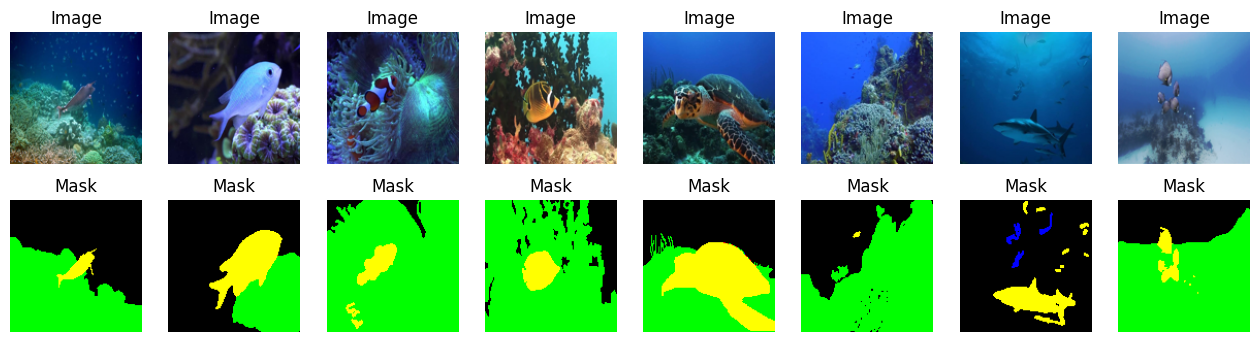

In [10]:
show_data(train_loader)

#### Демонстрация изображений и их масок из тестовой выборки:

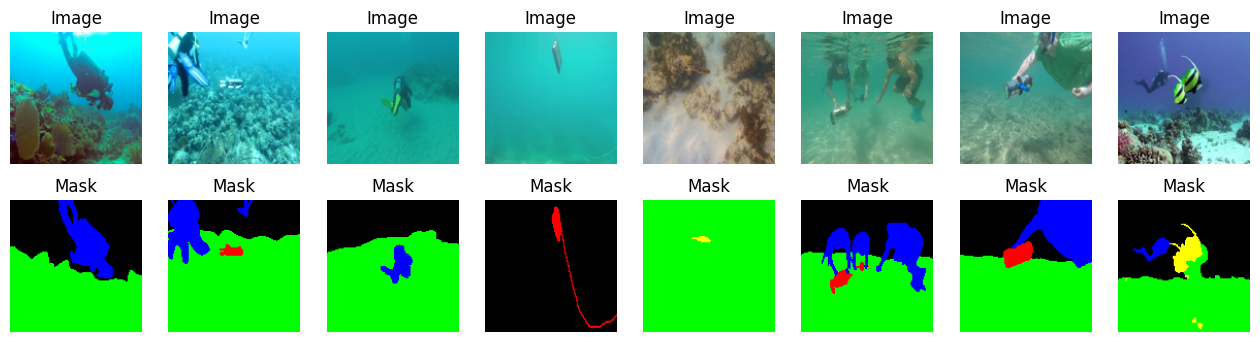

In [11]:
show_data(test_loader)

## U-Net parts

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## U-Net model

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 5):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.dropout = nn.Dropout(0.5)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.dropout(x4)
        x6 = self.down4(x5)
        x = self.dropout(x6)

        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

## Обучение модели

In [14]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = torch.nn.BCELoss()

In [16]:
for epoch in range(epochs):
    train_loss = []
    start_time = time.time()
    for data, mask in train_loader:
        data = data.permute(0, 3, 1, 2).to(device)
        mask = mask.permute(0, 3, 1, 2).to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

    train_time = time.time() - start_time
    mean_loss = torch.stack(train_loss).mean()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss = {mean_loss:.4f}')
    print(f'Time = {train_time:.4f} seconds')
    print()

Epoch [1/80], Loss = 0.2709
Time = 16.9632 seconds

Epoch [2/80], Loss = 0.2488
Time = 17.0161 seconds

Epoch [3/80], Loss = 0.2361
Time = 17.0902 seconds

Epoch [4/80], Loss = 0.2220
Time = 17.1890 seconds

Epoch [5/80], Loss = 0.2094
Time = 17.2945 seconds

Epoch [6/80], Loss = 0.2034
Time = 17.3116 seconds

Epoch [7/80], Loss = 0.1944
Time = 17.2944 seconds

Epoch [8/80], Loss = 0.1842
Time = 17.3299 seconds

Epoch [9/80], Loss = 0.1796
Time = 17.3084 seconds

Epoch [10/80], Loss = 0.1746
Time = 17.3069 seconds

Epoch [11/80], Loss = 0.1668
Time = 17.3100 seconds

Epoch [12/80], Loss = 0.1686
Time = 17.3302 seconds

Epoch [13/80], Loss = 0.1668
Time = 17.3370 seconds

Epoch [14/80], Loss = 0.1557
Time = 17.3728 seconds

Epoch [15/80], Loss = 0.1543
Time = 17.4035 seconds

Epoch [16/80], Loss = 0.1482
Time = 17.4225 seconds

Epoch [17/80], Loss = 0.1470
Time = 17.4341 seconds

Epoch [18/80], Loss = 0.1466
Time = 17.4677 seconds

Epoch [19/80], Loss = 0.1413
Time = 17.5108 seconds

Ep

## Функция для вычисления IoU

In [22]:
def compute_iou(labels, preds):
    intersection = np.logical_and(labels, preds)
    union = np.logical_or(labels, preds)
    iou_score = np.sum(intersection) / (0.0001 + np.sum(union))
    return iou_score

## Тестирование

In [23]:
accuracy, IoU_list = [], []
cm_preds, cm_masks = [], []
num_classes = 5
with torch.no_grad():
    for data, mask in test_loader:
        data = data.permute(0, 3, 1, 2).to(device)
        mask = mask.permute(0, 3, 1, 2).numpy()
        output = model(data)

        pred_mask = torch.where(output < torch.tensor(0.5), torch.tensor(0), torch.tensor(1)).cpu().numpy()

        for k in range(num_classes):
            mask_5_int = mask[:, k, :, :]
            predict_5_int = pred_mask[:, k, :, :]

            mask_5_int = np.where(mask_5_int != 1, 0, k + 1)
            predict_5_int = np.where(predict_5_int != 1, 0, k + 1)
            mask[:, k, :, :] = mask_5_int
            pred_mask[:, k, :, :] = predict_5_int

        cm_masks.append(mask)
        cm_preds.append(pred_mask)

        temp_acc, temp_iou = [], []
        for k in range(num_classes):
            acc = np.mean(pred_mask[:, k, :, :] == mask[:, k, :, :])
            IoU = compute_iou(mask[:, k, :, :], pred_mask[:, k, :, :])
            temp_acc.append(acc)
            temp_iou.append(IoU)
        accuracy.append(temp_acc)
        IoU_list.append(temp_iou)

accuracy = np.array(accuracy)
IoU_list = np.array(IoU_list)

print(f'Class accuracy = {np.mean(accuracy, axis = 0, dtype = np.float16)}')
print(f'Mean accuracy = {np.mean(accuracy, dtype = np.float16):.4f}')
print(f'Class IoU = {np.mean(IoU_list, axis = 0, dtype = np.float16)}')
print(f'Mean IoU = {np.mean(IoU_list, dtype = np.float16):.4f}')

Class accuracy = [0.926  0.9814 0.995  0.9453 0.8916]
Mean accuracy = 0.9482
Class IoU = [0.825  0.4    0.2634 0.3901 0.8037]
Mean IoU = 0.5366


## Визуализация confusion matrix

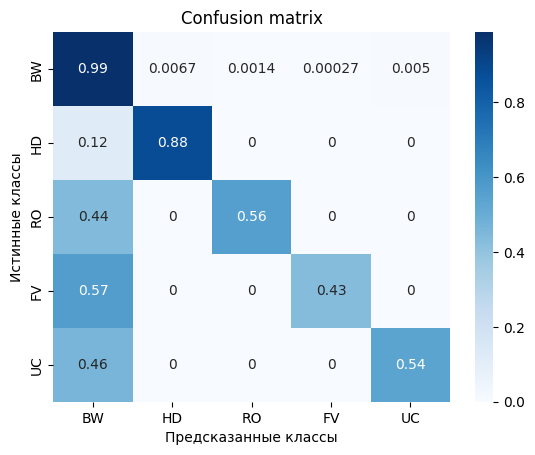

In [24]:
all_preds = np.concatenate(cm_preds, axis = 0)
all_masks = np.concatenate(cm_masks, axis = 0)

name_class = ['BW', 'HD', 'RO', 'FV', 'UC']
cm = confusion_matrix(all_masks.flatten(), all_preds.flatten(), labels=np.arange(num_classes), normalize='true')
sea.heatmap(cm, annot = True, cmap = 'Blues', xticklabels = name_class, yticklabels = name_class)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion matrix')
plt.show()

## Визуализация результатов

In [27]:
def visualize_results(dataset, num_img = 8):
    fig, axs = plt.subplots(3, num_img, figsize=(16, 6))
    for image, mask in dataset:
        image_ = image.permute(0, 3, 1, 2).to(device)
        output = model(image_)
        pred_mask = torch.where(output < torch.tensor(0.5), torch.tensor(0), torch.tensor(1)).permute(0, 2, 3, 1).cpu()

        for j in range(num_img):
            axs[0, j].imshow(image[j])
            axs[0, j].set_title('Image')
            axs[0, j].axis('off')

            mask_RGB = [[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0], [0, 1, 0]]
            RGB_mask = np.zeros((image_size[0], image_size[1], 3))
            for k in range(5):
                mask_ = mask[j, :, :, k]
                RGB_mask[mask_ > 0] = mask_RGB[k]
            axs[1, j].imshow(RGB_mask)
            axs[1, j].set_title('True Mask')
            axs[1, j].axis('off')

            RGB_pred_mask = np.zeros((image_size[0], image_size[1], 3))
            for k in range(5):
                mask_ = pred_mask.numpy()[j, :, :, k]
                RGB_pred_mask[mask_ > 0] = mask_RGB[k]
            axs[2, j].imshow(RGB_pred_mask)
            axs[2, j].set_title('Predicted Mask')
            axs[2, j].axis('off')

        break
    plt.show()

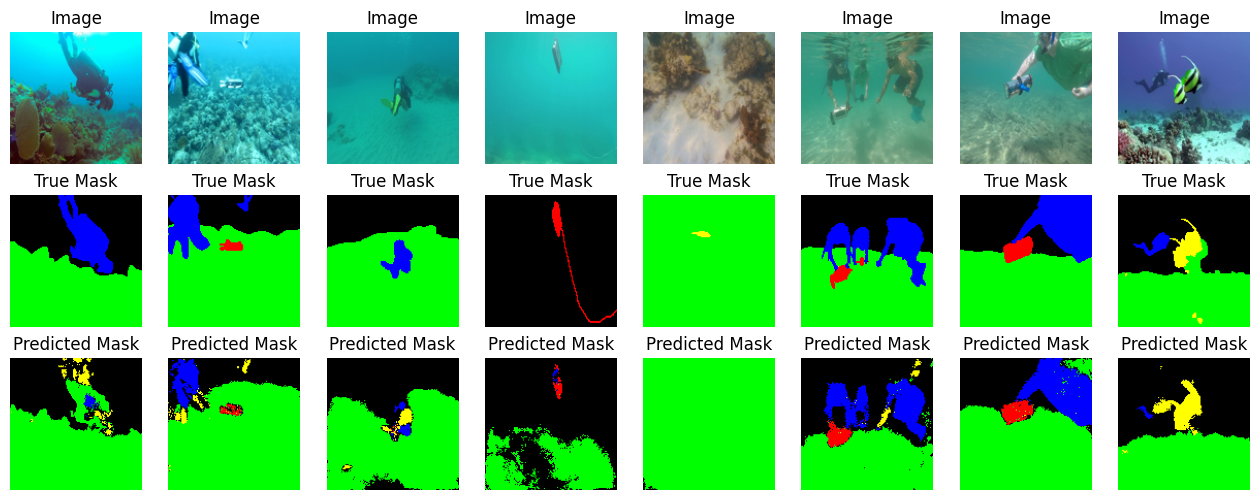

In [28]:
visualize_results(test_loader)